In [1]:
import nltk  # Importing the NLTK library, a powerful toolkit for natural language processing.
import string  # Importing the string library for working with strings in Python.
import re  # Importing the regular expression library for pattern matching.
import os  # Importing the os library for interacting with the operating system.
import numpy as np  # Importing NumPy for numerical operations, especially working with arrays.
import pandas as pd  # Importing Pandas for data manipulation and analysis, providing data structures like DataFrames.
import seaborn as sns  # Importing Seaborn for statistical data visualization based on Matplotlib.
import matplotlib.pyplot as plt  # Importing Matplotlib for creating various types of static, interactive, and animated visualizations in Python.
from sklearn.preprocessing import StandardScaler  # Importing StandardScaler from scikit-learn to standardize features by removing the mean and scaling to unit variance.
from sklearn.decomposition import PCA  # Importing Principal Component Analysis (PCA) from scikit-learn for dimensionality reduction techniques.
from collections import Counter  # Importing Counter from the collections library to count occurrences of items in a sequence.
from nltk.corpus import stopwords  # Importing stopwords from the NLTK corpus, which is a list of commonly used words that are often removed from text.
from nltk.stem import SnowballStemmer  # Importing SnowballStemmer from NLTK for stemming text, reducing words to their root form.
from sklearn.feature_extraction.text import CountVectorizer  # Importing CountVectorizer from scikit-learn for converting text data into a matrix of word counts.
from sklearn.model_selection import train_test_split  # Importing train_test_split from scikit-learn for splitting data into training and testing sets.
from sklearn.preprocessing import LabelEncoder  # Importing LabelEncoder from scikit-learn for converting categorical labels into numerical labels.
from sklearn.svm import SVC  # Importing Support Vector Classifier (SVC) from scikit-learn for classification tasks.
from sklearn.metrics import classification_report, balanced_accuracy_score  # Importing classification_report and balanced_accuracy_score from scikit-learn for evaluating classification models.
from sklearn.linear_model import LogisticRegression  # Importing LogisticRegression from scikit-learn for performing logistic regression.
from sklearn.tree import DecisionTreeClassifier, plot_tree  # Importing DecisionTreeClassifier and plot_tree from scikit-learn for building and visualizing decision trees.


In [2]:
#nltk.download('stopwords')

Construir Bag of Word a partir de textos

In [3]:
# Define preprocessing function
def preprocess(text, stemmer, stop_words):
    # Lowercase the input text to ensure consistent processing.
    text = text.lower()
    # Remove punctuation and numbers from the text.
    # This step helps to remove noise and improves the quality of the processed text.
    text = re.sub(r'[\d]+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize the text into individual words or tokens.
    tokens = text.split()
    # Remove stop words and stem the remaining tokens.
    # Stop words are common words (e.g., "the", "a", "is") that are typically removed to focus on important terms.
    # Stemming reduces words to their root form.
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words and len(word) >= 2]
    return ' '.join(tokens)

In [4]:
def process_scripts(directory, k, language):
    """
    Processes a directory of text files, applying the preprocessing steps,
    retaining only the k most common words across all texts, and returning
    a CountVectorizer object.

    Args:
        directory: The path to the directory containing the text files.
        k: Number of most common words to retain.

    Returns:
        A tuple (X, vectorizer) where X is the matrix representation of the 
        processed texts, and vectorizer is the CountVectorizer used.
    """
    all_texts = []
    seasons = []
    episodes = []

    stemmer = SnowballStemmer(language)  # Or "spanish" if your texts are in Spanish
    stop_words = set(stopwords.words(language))
    
    # Collect all texts and filenames
    for filename in os.listdir(directory):
        if filename.endswith(".txt"):  # Process only .txt files
            filepath = os.path.join(directory, filename)
            with open(filepath, 'r', encoding='utf-8-sig') as f:
                text = f.read()
                processed_text = preprocess(text, stemmer, stop_words)
                all_texts.append(processed_text)    # Append original processed text for later use
                seasons.append(filename[1:3])     # Save the season number
                episodes.append(filename[4:6])  # Save the episode number

    # Flatten list of lists to a single list and count word frequencies
    all_word_list = [word for text in all_texts for word in text.split()]
    most_common_words = [word for word, _ in Counter(all_word_list).most_common(k)]
    vectorizer = CountVectorizer(min_df=1, vocabulary=most_common_words)
    X = vectorizer.fit_transform(all_texts)
    
    return X, vectorizer, seasons, episodes

In [5]:
X, vectorizer, seasons, episodes = process_scripts ('./simpsons_scripts',150,"english")

In [6]:
X_dense = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
df_episodes = pd.DataFrame({"season": seasons, "episode": episodes})
df_episodes['era'] = df_episodes.apply(lambda row: "golden age" if int(row["season"]) <= 8 else "modern age", axis=1)

# Merge chapter information
df_simpsons_full = pd.concat([X_dense, df_episodes], axis=1)


In [7]:
# Create a LabelEncoder object to convert categorical author names into numerical values.
label_encoder = LabelEncoder()
# Fit the LabelEncoder to the 'author' column of the DataFrame and transform it into numerical values.
# These numerical values are then stored in the 'y' variable.
y = label_encoder.fit_transform(df_episodes['era'])
# Split the data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X_dense, y, test_size=0.4, random_state=42)

In [8]:
# Scale the data to have zero mean and unit variance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_dense)

# Perform Principal Component Analysis (PCA) to reduce data to 2 dimensions
pca = PCA(n_components=2)
pca_data = pca.fit_transform(X_scaled)

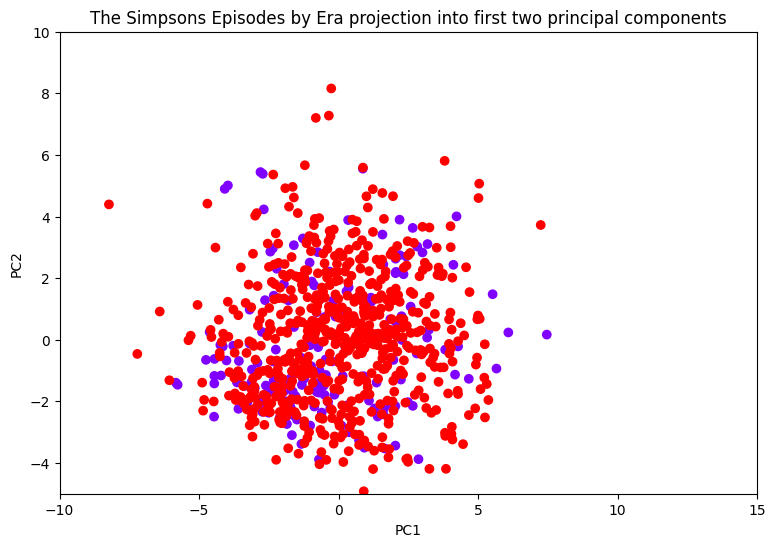

In [9]:
# Create a scatter plot of the data in the first two principal components.
# The color of each point is determined by the corresponding class label.
plt.figure(figsize=(9,6))
plt.scatter(pca_data[:,0],pca_data[:,1], c = y, cmap = 'rainbow')
plt.xlim(-10, 15)
plt.ylim(-5,10)
# Add a title to the plot.
plt.title('The Simpsons Episodes by Era projection into first two principal components')
# Label the x-axis as "PC1" (first principal component)
plt.xlabel("PC{}".format(1))
# Label the y-axis as "PC2" (second principal component)
plt.ylabel("PC{}".format(2))
# Display the plot
plt.show()

In [10]:
# This line trains the Support Vector Machine (SVM) classifier using the training data.
svm_classifier = SVC(kernel='linear', probability = True, class_weight='balanced')
svm_classifier.fit(X_train, y_train)

# This line makes predictions on the complete dataset using the trained SVM classifier.
# The predicted labels are stored in the variable 'y_svm'.
y_svm = svm_classifier.predict(X_dense)

In [11]:
# This code prints the SVM classification report for the Oz books dataset.
print("The Simpsons Episodes SVM era classification report:")
print(classification_report(y, y_svm, target_names=label_encoder.classes_))

The Simpsons Episodes SVM era classification report:
              precision    recall  f1-score   support

  golden age       0.84      0.89      0.86       178
  modern age       0.97      0.95      0.96       605

    accuracy                           0.93       783
   macro avg       0.90      0.92      0.91       783
weighted avg       0.94      0.93      0.94       783



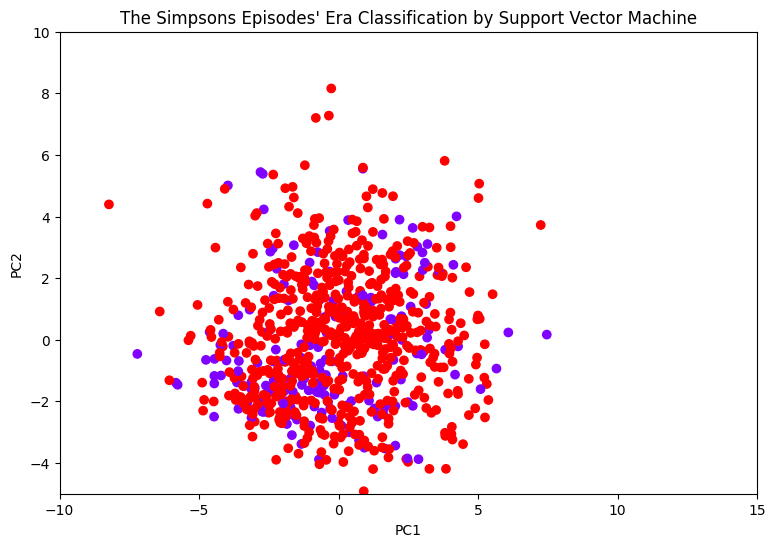

In [12]:
# This code generates a scatter plot of the first two principal components of the PCA data, colored by the predicted class labels from the SVM model.
plt.figure(figsize=(9,6))
# Generate a scatter plot with PC1 on the x-axis and PC2 on the y-axis.
plt.scatter(pca_data[:,0],pca_data[:,1], c = y_svm, cmap = 'rainbow')
# Set the x-axis limits for better visualization.
plt.xlim(-10, 15)
# Set the y-axis limits for better visualization.
plt.ylim(-5,10)
# Add a title to the plot.
plt.title("The Simpsons Episodes' Era Classification by Support Vector Machine")
# Add an x-axis label.
plt.xlabel("PC{}".format(1))
# Add a y-axis label.
plt.ylabel("PC{}".format(2))
# Display the plot.
plt.show()

In [13]:
# This line trains the Logistic Regression model using the training data.
# max_iter = 1000 sets the maximum number of iterations for the optimization algorithm.
# solver='newton-cg' specifies the solver to be used, in this case, Newton-Conjugate Gradient.
# penalty = 'l2' applies L2 regularization to the model, preventing overfitting.
# C = 0.5 sets the regularization strength.
lr_classifier = LogisticRegression(max_iter = 1000, solver = 'newton-cg', penalty = 'l2', C = 0.5, class_weight = 'balanced')
lr_classifier.fit(X_train, y_train)

# Make predictions on the test set
# This line makes predictions on the dataset using the trained Logistic Regression model.
y_lr = lr_classifier.predict(X_dense)


In [14]:
print("The Simpsons' episodes LR era classification report:")
print(classification_report(y, y_lr, target_names=label_encoder.classes_))


The Simpsons' episodes LR era classification report:
              precision    recall  f1-score   support

  golden age       0.82      0.89      0.85       178
  modern age       0.97      0.94      0.95       605

    accuracy                           0.93       783
   macro avg       0.89      0.92      0.90       783
weighted avg       0.93      0.93      0.93       783



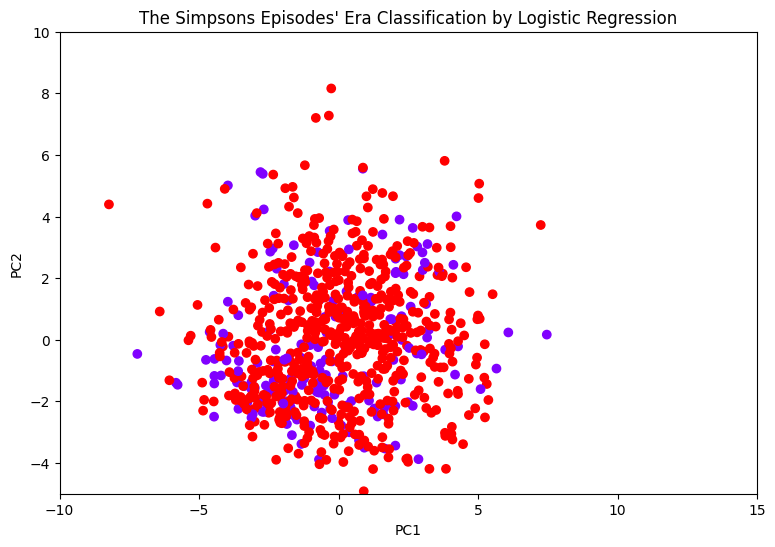

In [15]:
# This code generates a scatter plot to visualize the classification of Oz books' authors using logistic regression.
plt.figure(figsize=(9,6))
# Creates a new figure with a specified size (width=9 inches, height=6 inches).
plt.scatter(pca_data[:,0],pca_data[:,1], c = y_lr, cmap = 'rainbow')
# Creates a scatter plot with two dimensions of the principal component data (PC1 and PC2) as x and y coordinates.
# The color of each point is determined by the predicted class labels (y_lr) using the 'rainbow' colormap.
plt.xlim(-10, 15)
# Sets the x-axis limits to range from -10 to 15.
plt.ylim(-5,10)
# Sets the y-axis limits to range from -5 to 10.
plt.title("The Simpsons Episodes' Era Classification by Logistic Regression")
# Sets the title of the plot.
plt.xlabel("PC{}".format(1))
# Sets the label for the x-axis.
plt.ylabel("PC{}".format(2))
# Sets the label for the y-axis.
plt.show()

In [16]:
# Train decision tree
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Find optimal ccp_alpha for pruning by obtaining cost complexity path
path = clf.cost_complexity_pruning_path(X_train, y_train)
# Extract ccp_alphas excluding max alpha which prunes everything
ccp_alphas = path.ccp_alphas[:-1]

# Train Decision Trees with different ccp_alpha values
# This will evaluate the effect of pruning on model performance
clfs = [DecisionTreeClassifier(ccp_alpha=alpha, random_state=42).fit(X_train, y_train) for alpha in ccp_alphas]

# Compute balanced accuracy scores for both training and test sets
train_scores = [balanced_accuracy_score(y_train, clf.predict(X_train)) for clf in clfs]
test_scores = [balanced_accuracy_score(y_test, clf.predict(X_test)) for clf in clfs]

# Select best alpha (where test accuracy is maximized)
best_alpha = ccp_alphas[np.argmax(test_scores)]
print(f"Optimal ccp_alpha: {best_alpha:.6f}")

# Train pruned decision tree
clf_pruned = DecisionTreeClassifier(ccp_alpha=best_alpha, random_state=42)

Optimal ccp_alpha: 0.010235


In [17]:
# This line trains the pruned classification model on the training data.
clf_pruned.fit(X_train, y_train)
# Predicti on the dataset using the trained pruned classifier.
y_clf = clf_pruned.predict(X_dense)

In [18]:
print("The Simpsons Episodes Decision Tree era classification report:")
print(classification_report(y, y_clf, target_names=label_encoder.classes_))


The Simpsons Episodes Decision Tree era classification report:
              precision    recall  f1-score   support

  golden age       0.65      0.64      0.64       178
  modern age       0.89      0.90      0.90       605

    accuracy                           0.84       783
   macro avg       0.77      0.77      0.77       783
weighted avg       0.84      0.84      0.84       783



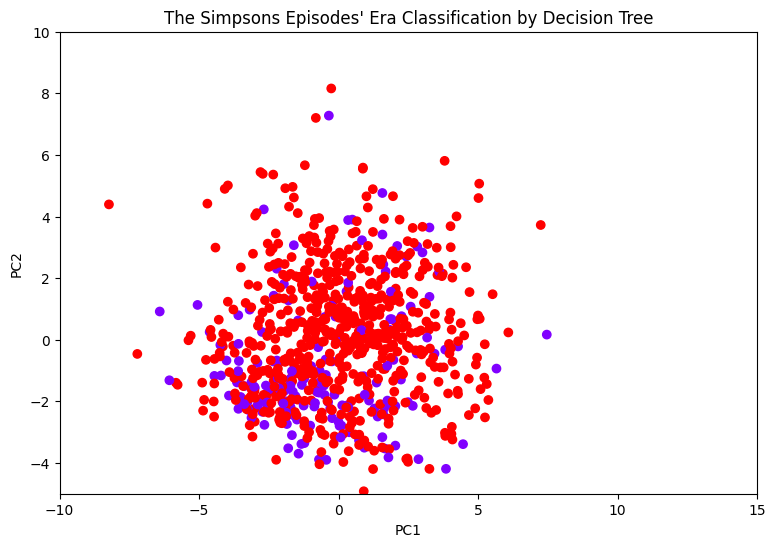

In [19]:
import matplotlib.pyplot as plt
# This line imports the matplotlib.pyplot module, which is used for creating plots.
plt.figure(figsize=(9,6))
# This line creates a new figure object with a specified size (width=9 inches, height=6 inches).
plt.scatter(pca_data[:,0],pca_data[:,1], c = y_clf, cmap = 'rainbow')
# This line creates a scatter plot using the principal component data (pca_data) along with the class labels (y_clf) and a rainbow color map.
plt.xlim(-10, 15)
# This line sets the x-axis limits of the plot to be between -10 and 15.
plt.ylim(-5,10)
# This line sets the y-axis limits of the plot to be between -5 and 10.
plt.title("The Simpsons Episodes' Era Classification by Decision Tree")
# This line sets the title of the plot to " Classification of Oz books\' authors".
# This line sets the title of the plot to " Classification of Oz books\' authors".
# This line sets the x-axis label of the plot to "PC{}".format(1), where PC1 is the first principal component.
plt.xlabel("PC{}".format(1))
# This line sets the y-axis label of the plot to "PC{}".format(2), where PC2 is the second principal component.
# This line sets the x-axis label of the plot to "PC{}".format(1), where PC1 is the first principal component.
plt.ylabel("PC{}".format(2))
# This line sets the y-axis label of the plot to "PC{}".format(2), where PC2 is the second principal component.
plt.show()
